# # Pose.mat


In [1]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    Activation,
    Dense,
    Dropout,
    Flatten,
    InputLayer,
)

from keras.models import (
    Sequential, 
    Model
)

from keras.applications import vgg16, ResNet50

In [2]:
poses = loadmat('../data/pose.mat')['pose']
poses = poses.transpose([3, 2, 0 ,1]).reshape(68, 13, 48, 40)

TRAIN_POSE_COUNT = 10
TEST_POSE_COUNT = 13 - TRAIN_POSE_COUNT
SUBJECT_COUNTS = 68

# Normalize the data as well
# using the first 10 poses of each subject for train
X_train = poses[:, :TRAIN_POSE_COUNT, :, :]/255.

# using the last 3 poses of each subject for test
X_test = poses[:, TRAIN_POSE_COUNT:, :, :]/255.

In [3]:
X_train.shape

(68, 10, 48, 40)

In [4]:
def combine_images(arr):
    """
    Param: (np.arr) numpy 4D array
    Return: (np.arr) numpy 2D array with images combined 
    """
    
    return arr.reshape(arr.shape[0] * arr.shape[1], arr.shape[2], arr.shape[3], 1)

X_train = combine_images(X_train)
X_test = combine_images(X_test)

In [5]:
def duplicate_channels(arr):
    """
    Param: (np.arr) numpy 4D array with 1 channel
    Returns: 
        (np.arr) numpy 4D array with 2 more duplicated channels 
        concatenated with the original array
    """

    arr = np.squeeze(np.stack((arr,) * 3, -1))
    return arr

X_train = duplicate_channels(X_train)
X_test = duplicate_channels(X_test)
X_train.shape, X_test.shape

((680, 48, 40, 3), (204, 48, 40, 3))

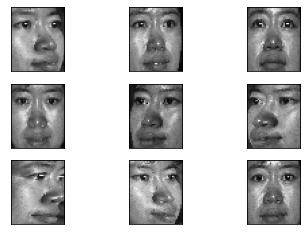

In [6]:
fig, ax = plt.subplots(3,3)

# first 9 images for one subject, each with a diff pose
for i, axis in enumerate(ax.flat):
    axis.imshow(X_train[i].squeeze(), cmap='bone')
    axis.set(xticks=[], yticks=[])

In [7]:
# each subject has 10 images consecutive in the train data 
y_train = np.concatenate([np.ones(TRAIN_POSE_COUNT) * i for i in range(X_train.shape[0] // TRAIN_POSE_COUNT)])
y_train = y_train.reshape(-1, 1)
# each subject has 3 images consecutive in the test data 
y_test = np.concatenate([np.ones(TEST_POSE_COUNT) * i for i in range(X_test.shape[0] // TEST_POSE_COUNT)])
y_test = y_test.reshape(-1, 1)

In [14]:
print(f"Train data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Train data shape: X_train: (680, 48, 40, 3), y_train: (680, 1)
Test data shape: X_test: (204, 48, 40, 3), y_test: (204, 1)


# Architecture
 The training accuracy was way higher than validation though, and we could not do much about it, with this much data models are bound to overfit, however, we did try adding Dropout. Another technique would be data augmentation which is cumbersome to implement.

 Transfer learning did not improve the performance either. We had to manipulate the image array for that to make it 3-channeled but even then it was almost the same as our normal model.

Due to the small dataset, the model overfits the data quite easily. To solve this problem and reduce it, we included Dropout and also reduced the deepness of the architecture.

 The most challenging hyperparameter to set was the learning rate. We believe `0.0007` to be the most optimized for our use.

In [15]:
model = None
model = Sequential(
    [
        Conv2D(filters=32,
            kernel_size=(3,3), 
            strides=(1,1),
            padding="same",
            kernel_initializer="glorot_uniform"),

        MaxPooling2D(pool_size=(2,2), 
            strides=(1,1),
            padding="valid",
            ),
     
        Activation(tf.nn.relu),

        Conv2D(filters=64, 
            kernel_size=(5,5),
            strides=2,
            padding="same", 
            kernel_initializer="glorot_uniform"),

        MaxPooling2D(pool_size=(2,2),
            strides=(1,1),
            padding="valid"), 
     
        Activation(tf.nn.relu),

        Flatten(),
        Dropout(0.7),

        Dense(SUBJECT_COUNTS, 
        kernel_initializer="glorot_uniform",
        activation="softmax")   
    ]
)

optimizer = keras.optimizers.Adam(learning_rate=0.00075)
model.compile(optimizer=optimizer, 
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

In [16]:
history = model.fit(X_train, y_train, 
                epochs=30, 
                validation_data=(X_test, y_test),
                verbose=2
            )

Epoch 1/30
22/22 - 2s - loss: 4.2514 - accuracy: 0.0074 - val_loss: 4.2191 - val_accuracy: 0.0343
Epoch 2/30
22/22 - 2s - loss: 4.2188 - accuracy: 0.0191 - val_loss: 4.2138 - val_accuracy: 0.0343
Epoch 3/30
22/22 - 2s - loss: 4.2068 - accuracy: 0.0426 - val_loss: 4.1728 - val_accuracy: 0.0392
Epoch 4/30
22/22 - 2s - loss: 4.0948 - accuracy: 0.0750 - val_loss: 3.9742 - val_accuracy: 0.0392
Epoch 5/30
22/22 - 2s - loss: 3.4822 - accuracy: 0.1941 - val_loss: 3.1684 - val_accuracy: 0.2696
Epoch 6/30
22/22 - 2s - loss: 2.1335 - accuracy: 0.5015 - val_loss: 2.7311 - val_accuracy: 0.3333
Epoch 7/30
22/22 - 2s - loss: 1.1085 - accuracy: 0.7000 - val_loss: 2.6493 - val_accuracy: 0.4216
Epoch 8/30
22/22 - 2s - loss: 0.7591 - accuracy: 0.8000 - val_loss: 2.6407 - val_accuracy: 0.4167
Epoch 9/30
22/22 - 2s - loss: 0.4772 - accuracy: 0.8853 - val_loss: 2.6640 - val_accuracy: 0.4951
Epoch 10/30
22/22 - 2s - loss: 0.3652 - accuracy: 0.9015 - val_loss: 2.3607 - val_accuracy: 0.5490
Epoch 11/30
22/22 -

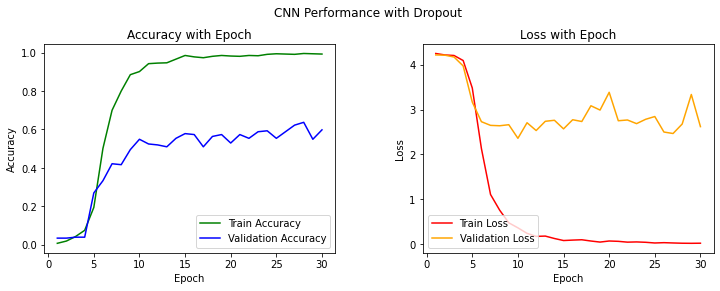

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle("CNN Performance with Dropout")
fig.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1, 31))
ax1.plot(epochs, history.history['accuracy'], label="Train Accuracy", color="green")
ax1.plot(epochs, history.history['val_accuracy'], label="Validation Accuracy", color="blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy with Epoch")
l1 = ax1.legend(loc="lower right")

epochs = list(range(1, 31))
ax2.plot(epochs, history.history['loss'], label="Train Loss", color="red")
ax2.plot(epochs, history.history['val_loss'], label="Validation Loss", color="orange")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.set_title("Loss with Epoch")
l1 = ax2.legend(loc="lower left")

For the Transfer Learning and Data Augmentation, we got help from the resource of Andrew Ng's videos that goes through some architectures like Inception, ResNets, and VGG.

In [19]:
INPUT_SHAPE = (48, 40, 3)
vgg = vgg16.VGG16(include_top=False,
                  weights="imagenet",
                  input_shape=INPUT_SHAPE,
                )

output = vgg.layers[-1].output
output = Flatten()(output)
vgg_model = Model(inputs=vgg.input, outputs=output, name="vgg_feature_extractor")

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False   

vgg_model.summary()  

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg_feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 40, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 40, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 40, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 20, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 20, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 20, 128)       147584    
______________________________________________

In [20]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=1)

    assert features.shape == (input_imgs.shape[0], model.layers[-1].output.shape[1])
    return features
    
train_features = get_bottleneck_features(vgg_model, X_train)    
val_features = get_bottleneck_features(vgg_model, X_test)

print("Train features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)

7/7 [==============================] - 0s 43ms/step
Train features shape: (680, 512)
Validation features shape: (204, 512)


In [21]:
input_shape = vgg_model.output.shape[1]

model = Sequential()

model.add(InputLayer(input_shape=(input_shape,)))

model.add(Dense(512, 
        activation='relu',
        input_dim=input_shape
    ))

model.add(Dropout(0.3))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(SUBJECT_COUNTS, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.00075),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 68)                34884     
Total params: 560,196
Trainable params: 560,196
Non-trainable params: 0
_________________________________________________________________


In [22]:
print(f"Train data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Train data shape: X_train: (680, 48, 40, 3), y_train: (680, 1)
Test data shape: X_test: (204, 48, 40, 3), y_test: (204, 1)


In [23]:
history = model.fit(x=train_features,
                    y=y_train,
                    validation_data=(val_features, y_test),
                    epochs=100,
                    verbose=1)

Epoch 1/100
22/22 [==============================] - 0s 5ms/step - loss: 4.3301 - accuracy: 0.0191 - val_loss: 4.1122 - val_accuracy: 0.0784
Epoch 2/100
22/22 [==============================] - 0s 2ms/step - loss: 4.0553 - accuracy: 0.0632 - val_loss: 3.9543 - val_accuracy: 0.1471
Epoch 3/100
22/22 [==============================] - 0s 2ms/step - loss: 3.8101 - accuracy: 0.0941 - val_loss: 3.6851 - val_accuracy: 0.2353
Epoch 4/100
22/22 [==============================] - 0s 2ms/step - loss: 3.4880 - accuracy: 0.1676 - val_loss: 3.3655 - val_accuracy: 0.2941
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 3.1111 - accuracy: 0.2191 - val_loss: 3.0739 - val_accuracy: 0.3382
Epoch 6/100
22/22 [==============================] - 0s 2ms/step - loss: 2.7991 - accuracy: 0.2647 - val_loss: 2.8746 - val_accuracy: 0.3529
Epoch 7/100
22/22 [==============================] - 0s 2ms/step - loss: 2.4783 - accuracy: 0.3397 - val_loss: 2.6703 - val_accuracy: 0.3627
Epoch 8/100
2

In [52]:
percent_accuracies = [acc[f'neighbors_{i+1}'] for i, acc in enumerate(knn_accuracies)]
classfication_count = [count(acc, X_test.shape[0]) for acc in percent_accuracies]
classfication_count

[{'accuracy': 0.7475490196078431, 'correct': 305, 'misclassified': 103},
 {'accuracy': 0.49754901960784315, 'correct': 203, 'misclassified': 205},
 {'accuracy': 0.5073529411764706, 'correct': 207, 'misclassified': 201},
 {'accuracy': 0.49754901960784315, 'correct': 203, 'misclassified': 205}]